In [1]:
# Estimates \pi on a quantum circuit with n cubits. The algorithm iteratively searches for a solution
# to the equation f(x) - x = 0, where f is a quantum circuit parameterized by one parameter. This 
# parameter represents an estimate of pi and is used instead of the actual value of pi in the inverse 
# quantum fourier transform . With x = \pi, the equation f(x) = x is satisfied with equality. The error
# of the estimate decreases with the number of cubits. The actual secant search is done classically.

import operator
from  qiskit import *
from numpy import abs

In [2]:
#initialization
def initialize_qubits(qc, measurement_qubits, target_qubit):
    qc.h(measurement_qubits)
    qc.x(target_qubit)

In [3]:
#improper qft inverse using an estimate of pi
def apply_improper_iqft(qc, measurement_qubits, n):
    def f(pi_est):
        for x in measurement_qubits:
            if x < (n-1)/2: qc.swap(x,n-1-x)

        for target_qubit in reversed(measurement_qubits):
            for control_qubit in reversed(range(target_qubit+1,n)):
                k = target_qubit - control_qubit - 1
                exponent = -2**(k)
                qc.cp(2*pi_est*exponent, control_qubit, target_qubit)
            qc.h(target_qubit)
            qc.barrier()
    return f

In [4]:
def qpe_program(n, pi_est):
    # Create a quantum circuit on n+1 qubits (n measurement, 1 target)
    qc = QuantumCircuit(n+1, n)

    # Initialize the qubits
    initialize_qubits(qc, range(n), n)

    # Apply the controlled unitary operators in sequence
    for x in range(n):
        exponent = 2**(n-x-1)
        qc.cp(1*exponent, x, n)

    qc.barrier()
    # Apply the "improper inverse quantum Fourier transform"
    apply_improper_iqft(qc, range(n), n)(pi_est)

    # Measure all qubits
    qc.measure(range(n), range(n))
  
    return qc

In [5]:
#run the circuit and measure pi
def measure_pi(n_qubits, qc, backend, n_shots):
    counts = execute(qc, backend=backend, shots=n_shots).result().get_counts(qc)
    
    highest_probability_outcome = max(counts.items(), key=operator.itemgetter(1))[0][::-1]
    return 2**(n_qubits-1) / int(highest_probability_outcome, 2)

In [6]:
#implements secant search starting from two given guesses 
def estimate_pi(n_qubits, first_guess, second_guess, n_shots, backend, max_iter):
    pi_est = first_guess
    qc = qpe_program(n_qubits, pi_est)
    measured = measure_pi(n_qubits, qc, backend, n_shots)
    
    pi_est_last = second_guess
    qc = qpe_program(n_qubits, pi_est_last)
    measured_last = measure_pi(n_qubits, qc, backend, n_shots)
    for k in range(max_iter):
        tmp = pi_est
        delta = measured - pi_est - measured_last + pi_est_last
        converged = abs(delta) < 1e-16
        if converged:
            print("using ", n_qubits, " qubits, converged after ", k, " iterations")
            return pi_est, measured
        else:
            pi_est = pi_est - (pi_est - pi_est_last) / delta * (measured - pi_est)
            measured_last = measured
            pi_est_last = tmp
            qc = qpe_program(n_qubits, pi_est)
            measured = measure_pi(n_qubits, qc, backend, n_shots)
    print("failed to converge")
    return pi_est, measured

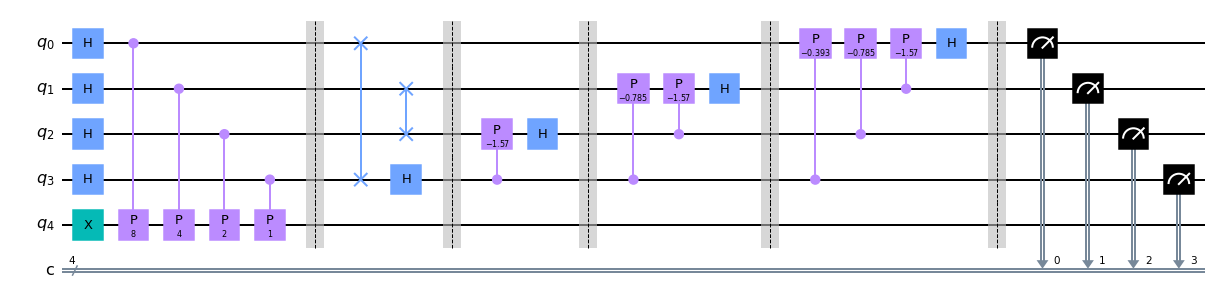

In [7]:
#draw the circuit for 4 qubits with a guessed value of pi
plot_guess = 3.14
qc = qpe_program(4, plot_guess)
qc.draw('mpl')

In [8]:
first_guess = 1
second_guess = 2
n_shots = 100
backend = Aer.get_backend('qasm_simulator')
max_iter = 200
for n_qubits in range(5, 20):
    qc_in, qc_out = estimate_pi(n_qubits, first_guess, second_guess, n_shots, backend, max_iter)
    print('Quantum circuit input:  '+str(qc_in))
    print('Quantum circuit output: '+str(qc_out)+'\n')
    

    

using  5  qubits, converged after  2  iterations
Quantum circuit input:  3.2
Quantum circuit output: 3.2

using  6  qubits, converged after  2  iterations
Quantum circuit input:  3.2
Quantum circuit output: 3.2

using  7  qubits, converged after  4  iterations
Quantum circuit input:  16.0
Quantum circuit output: 16.0

using  8  qubits, converged after  2  iterations
Quantum circuit input:  3.1219512195121952
Quantum circuit output: 3.1219512195121952

using  9  qubits, converged after  4  iterations
Quantum circuit input:  3.1604938271604937
Quantum circuit output: 3.1604938271604937

using  10  qubits, converged after  12  iterations
Quantum circuit input:  3.1411042944785277
Quantum circuit output: 3.1411042944785277

using  11  qubits, converged after  4  iterations
Quantum circuit input:  3.1411042944785277
Quantum circuit output: 3.1411042944785277

using  12  qubits, converged after  2  iterations
Quantum circuit input:  3.1411042944785277
Quantum circuit output: 3.14110429447852